## Imports of libraries and data

In [126]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

# # Imports for Pycox

# # For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

# import pycox as pc
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

In [127]:
interval_and_weather_merged = pd.read_csv('./interval_and_weather_merged.csv')
interval_and_weather_merged_reyna = pd.read_csv('./reyna_interval_and_weather_merge.csv')
df_list = [interval_and_weather_merged, interval_and_weather_merged_reyna ]
print(interval_and_weather_merged.shape)
print(interval_and_weather_merged_reyna.shape)
interval_and_weather_merged = pd.concat(df_list)

# interval_and_weather_merged

(298, 21)
(46, 21)


In [128]:
# Data Cleanup including Removing American Aster
interval_and_weather_merged = interval_and_weather_merged[(interval_and_weather_merged['sheet_title'] != '10-14-2022 i11 American Aster') & (interval_and_weather_merged['sheet_title'] != '10-14-2022 i8 American Aster')]

# Add status to the dataframe
interval_and_weather_merged = interval_and_weather_merged.assign(status=1)

# Convert to seconds for the interval
interval_and_weather_merged['interval'] = interval_and_weather_merged['interval'] / 1000000000

4561.0

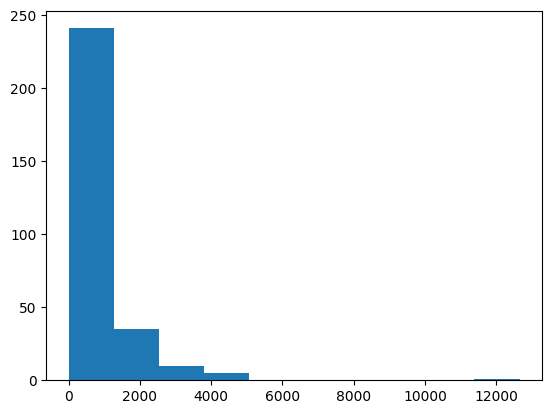

In [129]:
# Plot the distribution of the intervals
plt.hist(interval_and_weather_merged['interval'])

interval_and_weather_merged_greater_than_6000 = interval_and_weather_merged[(interval_and_weather_merged['interval'] <= 5)]
interval_and_weather_merged_greater_than_6000

# remove events with length larger than 5000
interval_and_weather_merged = interval_and_weather_merged[(interval_and_weather_merged['interval'] <= 5000)]
interval_and_weather_merged['interval'].max()

## Initial Cox Regression

In [130]:
interval_and_weather_merged.iloc[0]
# 2 minutes and 13 + 17 seconds = 30
# 150 seconds
# interval_and_weather_merged['interval'] = interval_and_weather_merged['interval'] / 1000000000

interval_and_weather_merged.iloc[0]


Unnamed: 0                                  0
endtime                       0 days 11:41:43
starttime                     0 days 11:44:13
interval                                150.0
departing_insect                      Insecta
arriving_insect                       Insecta
sheet_title             07-28-2022 i10 Zinnia
timestamp_pd              2022-07-28 11:41:43
timestamp_pd_rounded      2022-07-28 12:00:00
same_insect                                 1
temp                                     23.0
dwpt                                     23.0
rhum                                    100.0
prcp                                      0.0
snow                                      NaN
wdir                                    270.0
wspd                                      7.2
wpgt                                      NaN
pres                                   1014.0
tsun                                      NaN
coco                                      3.0
status                            

In [131]:
interval_and_weather_merged['interval']

0      150.0
1     1170.0
2      660.0
3      124.0
4       31.0
       ...  
41    3121.0
42      90.0
43    4411.0
44     600.0
45     839.0
Name: interval, Length: 291, dtype: float64

In [132]:
# Interval column is in nanoseconds
interval_cut_off = 1*60*1000*1000000
df_less_than_interval = interval_and_weather_merged[(interval_and_weather_merged['interval'] < interval_cut_off) & (interval_and_weather_merged['same_insect'] == True)]

df_minus_short_interval_same_insect = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= interval_cut_off) | (interval_and_weather_merged['same_insect'] == False)]
# df_minus_short_interval_same_insect

In [133]:
def run_cox_regression_on_all_data(interval_and_weather_merged):
  # JCB: List of ones to represent that all intervals have completed
  status = np.ones(interval_and_weather_merged.shape[0])

  mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                  interval_and_weather_merged, status=status, ties="efron")
  rslt = mod.fit()
  print(rslt.summary())

  return rslt
  
result = run_cox_regression_on_all_data(interval_and_weather_merged)

# status = np.ones(interval_and_weather_merged.shape[0])
# interval_and_weather_merged['status'] = status
# 

                         Results: PHReg
Model:                      PH Reg         Sample size:       291
Dependent variable:         interval       Num. events:       291
Ties:                       Efron                                
-----------------------------------------------------------------
             log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
same_insect  0.3785    0.1323 1.4600  2.8608 0.0042 1.1266 1.8922
temp         0.0523    0.0260 1.0537  2.0084 0.0446 1.0013 1.1088
wspd         0.0129    0.0145 1.0130  0.8890 0.3740 0.9846 1.0422
dwpt        -0.0922    0.0196 0.9119 -4.6961 0.0000 0.8774 0.9477
coco         0.3109    0.0582 1.3647  5.3393 0.0000 1.2175 1.5296
Confidence intervals are for the hazard ratios


In [134]:
# baseline_hazard = result.baseline_hazard[0] # baseline hazard at time 0
# sf = result.survival_function(data, times=[1000]) # survival function at time t=1000
# s_prob = sf[0][0]

print(result.__dir__())
print(result.params)
print(result.model)

['covariance_type', 'df_resid', 'df_model', 'params', 'model', 'k_constant', '_data_attr', '_data_in_cache', 'normalized_cov_params', 'scale', '_use_t', '_cache', '__module__', '__doc__', '__init__', 'standard_errors', 'bse', 'get_distribution', 'predict', '_group_stats', 'weighted_covariate_averages', 'score_residuals', 'baseline_cumulative_hazard', 'baseline_cumulative_hazard_function', 'schoenfeld_residuals', 'martingale_residuals', 'summary', '_get_robustcov_results', 'use_t', 'llf', 'tvalues', 'pvalues', 'cov_params', 't_test', 'f_test', 'wald_test', 'wald_test_terms', 't_test_pairwise', 'conf_int', 'save', 'load', 'remove_data', 'initialize', '__dict__', '__weakref__', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']
[ 0.37845869  0.05227543  0.01290065

### Checking proportional hazards assumption

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 291 total observations, 0 right-censored observations>
         test_name = proportional_hazard_test

---
                  test_statistic    p  -log2(p)
coco        km              4.32 0.04      4.73
            rank            4.32 0.04      4.73
dwpt        km              0.50 0.48      1.06
            rank            0.51 0.48      1.07
same_insect km              1.69 0.19      2.37
            rank            1.65 0.20      2.33
temp        km              4.90 0.03      5.22
            rank            4.78 0.03      5.12
wspd        km              1.58 0.21      2.26
            rank            1.55 0.21      2.23



1. Variable 'temp' failed the non-proportional test: p-value is 0.0268.

   Advice 1: the functional form of the variable 'temp' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'temp' using pd.cut, and then specify it in `strata=['temp',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'coco' failed the non-proportional test: p-value is 0.0376.

   Advice 1: the functional form of the variable 'coco' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below 

[[<Axes: xlabel='rank-transformed time\n(p=0.0288)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0268)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0377)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0376)'>]]

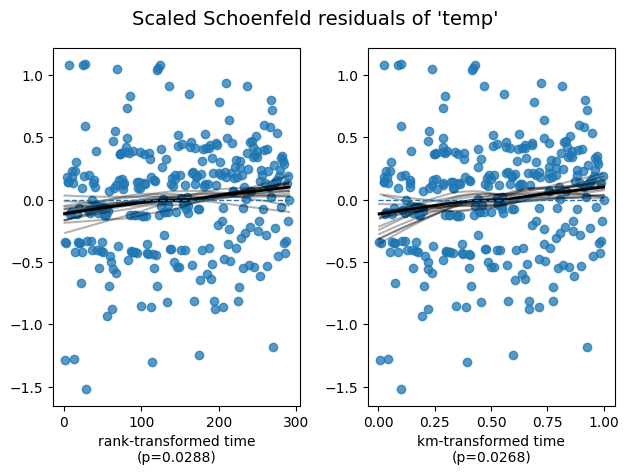

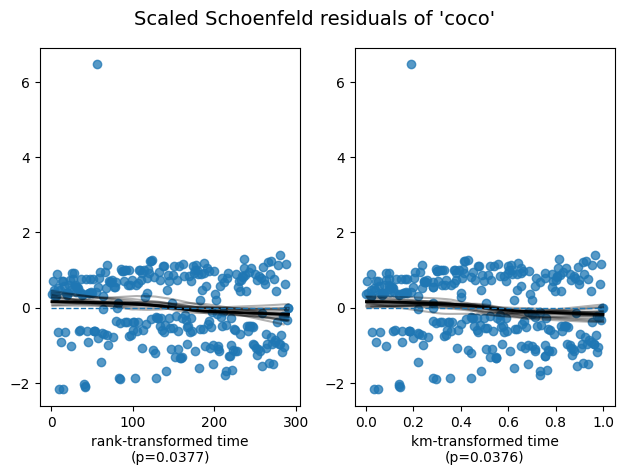

In [135]:
rossi = load_rossi()

# same_insect + temp + wspd + dwpt + coco
cph = CoxPHFitter()

trimmed_df = interval_and_weather_merged[['interval','status', 'same_insect' , 'temp' , 'wspd' , 'dwpt' , 'coco']].copy()
trimmed_df = trimmed_df.reset_index(drop=True)
cph.fit(trimmed_df, 'interval', 'status')
# cph.print_summary(model="untransformed variables", decimals=3)
cph.check_assumptions(trimmed_df, p_value_threshold=0.05, show_plots=True)
# trimmed_df


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/l

[[<Axes: xlabel='rank-transformed time\n(p=0.0007)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0009)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0068)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0063)'>]]

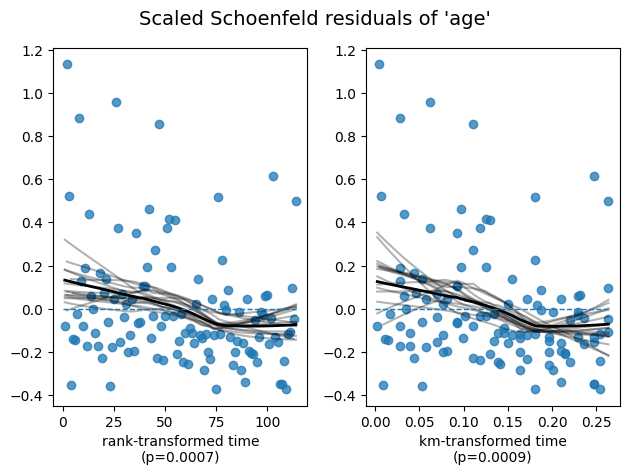

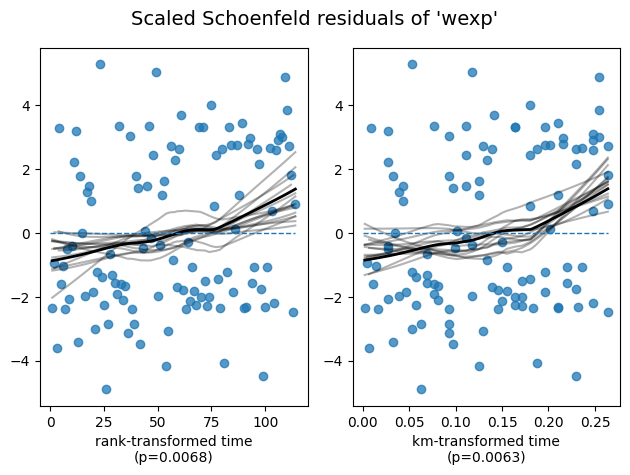

In [136]:
cph.fit(rossi, 'week', 'arrest')
cph.check_assumptions(rossi, p_value_threshold=0.05, show_plots=True)
# rossi

### Running classic cox regression with Lifelines on photo data
 

In [137]:
cph = CoxPHFitter()
cph.fit(interval_and_weather_merged, duration_col='interval', event_col='status', formula="same_insect + temp + wspd + dwpt + coco")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 291 total observations, 0 right-censored observations>
             duration col = 'interval'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 291
number of events observed = 291
   partial log-likelihood = -1334.97
         time fit was run = 2023-05-24 16:00:06 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
coco          0.31       1.36       0.06             0.20             0.43                 1.22                 1.53
dwpt         -0.09       0.91       0.02            -0.13            -0.05                 0.88                 0.95
same_insect   0.38       1.46       0.13             0.12             0.64                 1.13                 1.89
temp          0.05       1.05       0.03             0.00             0.10                 1.00                 1.11
wspd          0.01       1.01       0.01            -0.02             0.04                 0.98                 1.04

              cmp to     z      p   -log2(p)
covariate                                   
coco            0.00  5.34 <0.005      23.35
dwpt            0.00 -4.70 <0.005      18.52
same_insect     0.00  2.86 <0.005       7.89
temp            0.00  2.01   0.04       4.49
wspd            0.00  0.89   0.37       1.42
---
Concordance = 0.51
Partial AIC = 2679.94
log-likelihood ratio test = 57.44 on 5 df
-log2(p) of ll-ratio test = 34.51

### Notes from Tom
Qualitative 

In [138]:
def run_bin_temp_analysis(df, binned_column, number_of_bins):
    # Find the range of the `temp` column
    temp_min = df[binned_column].min()
    temp_max = df[binned_column].max()

    print(f"Photo data {binned_column} range")
    print(temp_min)
    print(temp_max)

    # Calculate the range of each group based on the total range of `temp`
    group_range = (temp_max - temp_min) / 3
    print(group_range)
    # Create a new column in the DataFrame to hold the temperature group for each row
    df['binned_group'] = pd.cut(df[binned_column], bins=[temp_min, temp_min+group_range, temp_min+2*group_range, temp_max], labels=['Low', 'Medium', 'High'])

    group_object = {}
    # Print out the DataFrame grouped by temperature group
    for name, group in interval_and_weather_merged.groupby('binned_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        group_object.update({name: group})
        group_temp_range = f"{name}: {group['temp'].min()} - {group['temp'].max()}"
        print('group_temp_range', group_temp_range)

        status = np.ones(len(group))

        cph = CoxPHFitter()
        cph.fit(group, duration_col='interval', event_col='status', formula="same_insect + temp + wspd + dwpt + coco")

        cph.print_summary()

        # mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
        #                 group, status=status, ties="efron")
        # rslt = mod.fit()
        # print(rslt.summary())
    return group_object
    
# df_minus_short_interval_same_insect

temp_groups = run_bin_temp_analysis(interval_and_weather_merged, 'temp', 3)

temp_groups

Photo data temp range
12.0
31.0
6.333333333333333
Group: Low

Number of rows in group: 80

group_temp_range Low: 14.0 - 18.0


<lifelines.CoxPHFitter: fitted with 80 total observations, 0 right-censored observations>
             duration col = 'interval'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 80
number of events observed = 80
   partial log-likelihood = -260.26
         time fit was run = 2023-05-24 16:00:06 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
coco          0.46       1.58       0.13             0.21             0.71                 1.24                 2.03
dwpt         -0.19       0.83       0.05            -0.30            -0.08                 0.74                 0.92
same_insect  -0.08       0.92       0.37            -0.80             0.64                 0.45                 1.89
temp         -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.18
wspd          0.02       1.02       0.02            -0.03             0.06                 0.97                 1.06

              cmp to     z      p   -log2(p)
covariate                                   
coco            0.00  3.65 <0.005      11.89
dwpt            0.00 -3.48 <0.005      10.95
same_insect     0.00 -0.22   0.83       0.27
temp            0.00 -0.46   0.65       0.63
wspd            0.00  0.65   0.51       0.96
---
Concordance = 0.69
Partial AIC = 530.52
log-likelihood ratio test = 26.83 on 5 df
-log2(p) of ll-ratio test = 13.99

Group: Medium

Number of rows in group: 156

group_temp_range Medium: 20.0 - 24.0


<lifelines.CoxPHFitter: fitted with 156 total observations, 0 right-censored observations>
             duration col = 'interval'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 156
number of events observed = 156
   partial log-likelihood = -618.74
         time fit was run = 2023-05-24 16:00:07 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
coco          0.31       1.37       0.09             0.14             0.49                 1.15                 1.63
dwpt         -0.10       0.91       0.03            -0.15            -0.05                 0.86                 0.95
same_insect   0.40       1.49       0.17             0.06             0.74                 1.06                 2.09
temp          0.04       1.04       0.08            -0.11             0.20                 0.90                 1.22
wspd          0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06

              cmp to     z      p   -log2(p)
covariate                                   
coco            0.00  3.46 <0.005      10.88
dwpt            0.00 -3.88 <0.005      13.22
same_insect     0.00  2.31   0.02       5.57
temp            0.00  0.55   0.58       0.78
wspd            0.00  0.49   0.62       0.69
---
Concordance = 0.51
Partial AIC = 1247.48
log-likelihood ratio test = 32.97 on 5 df
-log2(p) of ll-ratio test = 18.00

Group: High

Number of rows in group: 49

group_temp_range High: 25.0 - 31.0


<lifelines.CoxPHFitter: fitted with 49 total observations, 0 right-censored observations>
             duration col = 'interval'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 49
number of events observed = 49
   partial log-likelihood = -140.73
         time fit was run = 2023-05-24 16:00:07 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
coco         -0.12       0.89       0.25            -0.62             0.38                 0.54                 1.46
dwpt         -0.26       0.77       0.14            -0.53             0.01                 0.59                 1.01
same_insect   0.39       1.48       0.31            -0.21             0.99                 0.81                 2.70
temp          0.39       1.47       0.21            -0.02             0.79                 0.98                 2.21
wspd          0.02       1.02       0.05            -0.08             0.12                 0.92                 1.13

              cmp to     z    p   -log2(p)
covariate                                 
coco            0.00 -0.48 0.63       0.66
dwpt            0.00 -1.90 0.06       4.12
same_insect     0.00  1.28 0.20       2.31
temp            0.00  1.87 0.06       4.03
wspd            0.00  0.44 0.66       0.60
---
Concordance = 0.48
Partial AIC = 291.45
log-likelihood ratio test = 7.68 on 5 df
-log2(p) of ll-ratio test = 2.52

{'Low':      Unnamed: 0          endtime        starttime  interval  \
 14           14  0 days 12:02:30  0 days 12:17:00     870.0   
 15           15  0 days 12:17:30  0 days 12:29:00     690.0   
 16           16  0 days 12:29:30  0 days 12:39:00     570.0   
 126         262  0 days 00:09:54  0 days 00:10:26      32.0   
 127         263  0 days 00:12:39  0 days 00:13:18      39.0   
 ..          ...              ...              ...       ...   
 289         259  0 days 00:26:00  0 days 00:48:45    1365.0   
 290         260  0 days 00:48:56  0 days 01:09:20    1224.0   
 291         261  0 days 00:36:55  0 days 00:37:46      51.0   
 40           40  0 days 12:12:26  0 days 12:37:56    1530.0   
 41           43  0 days 12:17:54  0 days 13:09:55    3121.0   
 
             departing_insect          arriving_insect  \
 14   Melissodes denticulatus  Melissodes denticulatus   
 15   Melissodes denticulatus  Melissodes denticulatus   
 16   Melissodes denticulatus  Melissodes denticu

In [139]:
# Summary Stats about Reyna's Data
print(interval_and_weather_merged_reyna.temp.quantile([0.25,0.5,0.75]))

print(interval_and_weather_merged.temp.quantile([0.25,0.5,0.75]))

0.25    21.00
0.50    23.00
0.75    27.75
Name: temp, dtype: float64
0.25    16.5
0.50    22.0
0.75    23.0
Name: temp, dtype: float64


### New binning analysis function but for time

In [140]:
def run_bin_time_analysis(interval_and_weather_merged, binned_column, number_of_bins):
    # Convert the 'Timestamp' column to datetime format
    interval_and_weather_merged[binned_column] = pd.to_datetime(interval_and_weather_merged[binned_column])

    # Extract the hour component from each timestamp
    interval_and_weather_merged['hour_of_day'] = interval_and_weather_merged[binned_column].dt.hour

    # Calculate the range of the hour_of_day values
    time_min = interval_and_weather_merged['hour_of_day'].min()
    time_max = interval_and_weather_merged['hour_of_day'].max()

    print(f"Photo data {binned_column} range")
    print(time_min)
    print(type(time_min))
    print(time_max)

    # Calculate the range of each group based on the total range of hour_of_day
    group_range = (time_max - time_min) / number_of_bins
    print(group_range)

    # Create the bins for the pd.cut function
    bins = [time_min + i * group_range for i in range(number_of_bins + 1)]

    print('bins', bins)
    # Create a new column in the DataFrame to hold the time group for each row
    interval_and_weather_merged['time_group'] = pd.cut(
        interval_and_weather_merged['hour_of_day'],
        bins=bins,
        labels=[f'Group {i+1}' for i in range(number_of_bins)]
    )

    # Drop the intermediate hour_of_day column if needed
    # interval_and_weather_merged.drop('hour_of_day', axis=1, inplace=True)



    # Print out the DataFrame grouped by time group
    for name, group in interval_and_weather_merged.groupby('time_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        # print(group.head())
        status = np.ones(len(group))

        mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                        group, status=status, ties="efron")
        rslt = mod.fit()
        print(rslt.summary())
# df_minus_short_interval_same_insect

run_bin_time_analysis(interval_and_weather_merged, 'timestamp_pd_rounded', 3)

Photo data timestamp_pd_rounded range
12
<class 'numpy.int64'>
17
1.6666666666666667
bins [12.0, 13.666666666666666, 15.333333333333334, 17.0]
Group: Group 1

Number of rows in group: 38

                         Results: PHReg
Model:                     PH Reg          Sample size:        38
Dependent variable:        interval        Num. events:        38
Ties:                      Efron                                 
-----------------------------------------------------------------
             log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
same_insect  0.7276    0.4988 2.0700  1.4585 0.1447 0.7787 5.5029
temp        -0.0486    0.1315 0.9526 -0.3692 0.7120 0.7361 1.2327
wspd         0.0535    0.0511 1.0550  1.0468 0.2952 0.9544 1.1661
dwpt         0.0508    0.1228 1.0521  0.4135 0.6792 0.8270 1.3384
coco         0.1464    0.2185 1.1576  0.6699 0.5029 0.7544 1.7764
Confidence intervals are for the hazard ratios

In [141]:
interval_and_weather_merged

# Convert the 'Timestamp' column to datetime format
interval_and_weather_merged['timestamp_pd_rounded'] = pd.to_datetime(interval_and_weather_merged['timestamp_pd_rounded'])

# Find the earliest hour value
earliest_hour = interval_and_weather_merged['timestamp_pd_rounded'].dt.hour.max()

type(earliest_hour)
# pd.to_datetime(earliest_hour.astype(str)).values

# datetime_time_min = np.datetime64(earliest_hour, 'h')
interval_and_weather_merged['timestamp_pd_rounded']

0    2022-07-28 12:00:00
1    2022-07-28 12:00:00
2    2022-07-28 14:00:00
3    2022-08-04 13:00:00
4    2022-08-04 13:00:00
             ...        
41   2022-08-25 12:00:00
42   2022-08-25 13:00:00
43   2022-08-25 13:00:00
44   2022-08-25 13:00:00
45   2022-08-25 13:00:00
Name: timestamp_pd_rounded, Length: 291, dtype: datetime64[ns]

## Pycox Expirementation


In [159]:
# Step 1: Select relevant columns
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']
df_train = interval_and_weather_merged[cols_input]

# print(df_train['interval'].max())

# Step 2: Split data into training, validation, and test sets
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()

,interval,status,temp,dwpt,wspd,coco,same_insect
2,660.0,1,29.0,25.0,8.3,3.0,0
4,31.0,1,28.0,25.0,7.0,1.0,1
7,1620.0,1,21.0,18.9,6.0,3.0,1
8,90.0,1,23.0,18.1,7.6,3.0,1
9,901.0,1,23.0,18.1,7.6,3.0,1


In [160]:
cols_standardize = []
cols_leave = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
x_val

array([[4.860e+02, 1.000e+00, 1.400e+01, 1.000e+01, 7.000e-01, 3.000e+00,
        1.000e+00],
       [7.610e+02, 1.000e+00, 1.600e+01, 9.000e+00, 1.480e+01, 1.000e+00,
        1.000e+00],
       [4.471e+03, 1.000e+00, 2.300e+01, 1.700e+01, 9.400e+00, 1.000e+00,
        0.000e+00],
       [1.531e+03, 1.000e+00, 2.200e+01, 1.800e+01, 7.600e+00, 1.000e+00,
        1.000e+00],
       [3.000e+01, 1.000e+00, 2.500e+01, 1.700e+01, 1.300e+01, 3.000e+00,
        0.000e+00],
       [2.280e+02, 1.000e+00, 1.500e+01, 4.100e+00, 1.300e+01, 1.000e+00,
        1.000e+00],
       [9.280e+02, 1.000e+00, 2.400e+01, 2.210e+01, 1.300e+01, 3.000e+00,
        0.000e+00],
       [2.040e+02, 1.000e+00, 1.400e+01, 1.000e+01, 7.000e-01, 3.000e+00,
        1.000e+00],
       [1.380e+02, 1.000e+00, 2.500e+01, 1.700e+01, 1.300e+01, 3.000e+00,
        1.000e+00],
       [9.460e+02, 1.000e+00, 2.200e+01, 1.610e+01, 1.300e+01, 3.000e+00,
        0.000e+00],
       [9.000e+02, 1.000e+00, 2.400e+01, 2.210e+01, 1.300e+0

In [161]:
num_durations = 100

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['interval'].values, df['status'].values)

# I do not understand the output of the labtrans.fit_transform() function
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)
print(y_train)

(array([15,  1, 36,  2, 20,  1, 25, 21, 19, 15, 59, 32, 10, 38,  1,  1, 20,
       86, 14,  1,  2,  1,  2,  4,  1,  1,  5, 12,  2,  4,  2,  2, 11, 12,
        1,  1,  3, 16,  2, 10,  2,  5,  3,  3,  2,  3,  8, 15,  8,  1, 61,
        3,  4,  2,  3,  3,  4,  3,  3,  1,  2,  6,  5,  1,  3, 10,  2,  3,
        1, 59, 61, 42, 19,  4, 20, 47, 34,  6,  8,  2, 16, 38, 17, 15, 99,
       42, 17,  6, 46, 15,  7, 14,  7,  1,  1,  3,  5,  3,  1,  1,  1,  4,
        4, 13,  3, 19,  2,  8, 11, 11,  3, 73, 27, 30,  5, 56,  3,  4,  5,
        8,  8,  6, 12,  1,  2,  5,  2,  3,  1,  1,  4,  7,  3, 25,  4,  1,
        1, 10,  4,  7,  8, 41, 30, 27,  1,  1, 47, 47,  5,  1, 14, 10,  6,
        2,  2, 55, 17,  4,  5, 15, 11, 29, 66, 17, 68,  2]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.,

In [162]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
batch_size = 256
epochs = 100
bad_param = 'test'
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)



0:	[0s / 0s],		train_loss: 11.2134,	val_loss: 12.8149
1:	[0s / 0s],		train_loss: 9.5748,	val_loss: 10.0542
2:	[0s / 0s],		train_loss: 8.3892,	val_loss: 8.5413
3:	[0s / 0s],		train_loss: 7.2594,	val_loss: 7.4570
4:	[0s / 0s],		train_loss: 6.3293,	val_loss: 6.5935
5:	[0s / 0s],		train_loss: 5.4704,	val_loss: 5.8332
6:	[0s / 0s],		train_loss: 4.8954,	val_loss: 5.1927
7:	[0s / 0s],		train_loss: 4.2507,	val_loss: 4.6960
8:	[0s / 0s],		train_loss: 3.8313,	val_loss: 4.3110
9:	[0s / 0s],		train_loss: 3.5356,	val_loss: 4.0218
10:	[0s / 0s],		train_loss: 3.2858,	val_loss: 3.8096
11:	[0s / 0s],		train_loss: 3.1226,	val_loss: 3.6447
12:	[0s / 0s],		train_loss: 2.9922,	val_loss: 3.5155
13:	[0s / 0s],		train_loss: 2.8649,	val_loss: 3.4009
14:	[0s / 0s],		train_loss: 2.7838,	val_loss: 3.2960
15:	[0s / 0s],		train_loss: 2.6928,	val_loss: 3.2052
16:	[0s / 0s],		train_loss: 2.6266,	val_loss: 3.1281
17:	[0s / 0s],		train_loss: 2.5580,	val_loss: 3.0688
18:	[0s / 0s],		train_loss: 2.5150,	val_loss: 3.0173


### run_pycox_on_group function

0:	[0s / 0s],		train_loss: 10.7470,	val_loss: 13.9689
1:	[0s / 0s],		train_loss: 9.0980,	val_loss: 8.5878
2:	[0s / 0s],		train_loss: 7.7316,	val_loss: 6.3336
3:	[0s / 0s],		train_loss: 6.7014,	val_loss: 5.1018
4:	[0s / 0s],		train_loss: 5.8799,	val_loss: 4.3827
5:	[0s / 0s],		train_loss: 5.2530,	val_loss: 3.9817
6:	[0s / 0s],		train_loss: 4.7148,	val_loss: 3.7549
7:	[0s / 0s],		train_loss: 4.3564,	val_loss: 3.6141
8:	[0s / 0s],		train_loss: 3.9800,	val_loss: 3.5166
9:	[0s / 0s],		train_loss: 3.7149,	val_loss: 3.4327
10:	[0s / 0s],		train_loss: 3.5663,	val_loss: 3.3525
11:	[0s / 0s],		train_loss: 3.3531,	val_loss: 3.2756
12:	[0s / 0s],		train_loss: 3.2099,	val_loss: 3.2030
13:	[0s / 0s],		train_loss: 3.0594,	val_loss: 3.1307
14:	[0s / 0s],		train_loss: 2.9068,	val_loss: 3.0555
15:	[0s / 0s],		train_loss: 2.8320,	val_loss: 2.9885
16:	[0s / 0s],		train_loss: 2.7500,	val_loss: 2.9269
17:	[0s / 0s],		train_loss: 2.6066,	val_loss: 2.8616
18:	[0s / 0s],		train_loss: 2.5723,	val_loss: 2.8036
1

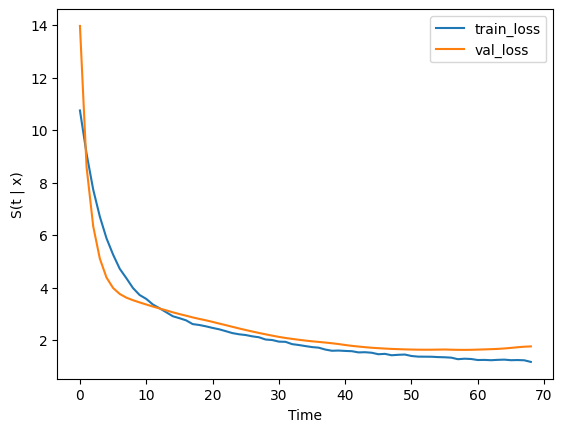

In [215]:
# Creating Pycox Function
def run_pycox_on_group(df_train):
  # Step 2: Split data into training, validation, and test sets
  df_test = df_train.sample(frac=0.2)
  df_train = df_train.drop(df_test.index)
  df_val = df_train.sample(frac=0.2)
  df_train = df_train.drop(df_val.index)

  cols_standardize = []
  cols_leave = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  x_mapper = DataFrameMapper(standardize + leave)
  x_train = x_mapper.fit_transform(df_train).astype('float32')
  x_val = x_mapper.transform(df_val).astype('float32')
  x_test = x_mapper.transform(df_test).astype('float32')

  num_durations = 100
  labtrans = LogisticHazard.label_transform(num_durations)
  get_target = lambda df: (df['interval'].values, df['status'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  y_val = labtrans.transform(*get_target(df_val))
  train = (x_train, y_train)
  val = (x_val, y_val)

  # We don't need to transform the test labels
  durations_test, events_test = get_target(df_test)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
  batch_size = 256
  epochs = 100
  bad_param = 'test'
  callbacks = [tt.cb.EarlyStopping()]
  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

  return log, model, x_test

def plot_training_val_loss(fit_model, base_model, x_test):
  _ = fit_model.plot()
  fit_model.to_pandas().val_loss.min()
  base_model.score_in_batches(val)
  surv = base_model.predict_surv_df(x_test)
  plt.ylabel('S(t | x)')
  _ = plt.xlabel('Time')
  surv.iloc[:, :1]

# Step 1: Select relevant columns
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']
df_train = interval_and_weather_merged[cols_input]
fit_model, base_model, x_test = run_pycox_on_group(df_train)


plot_training_val_loss(fit_model, base_model, x_test)

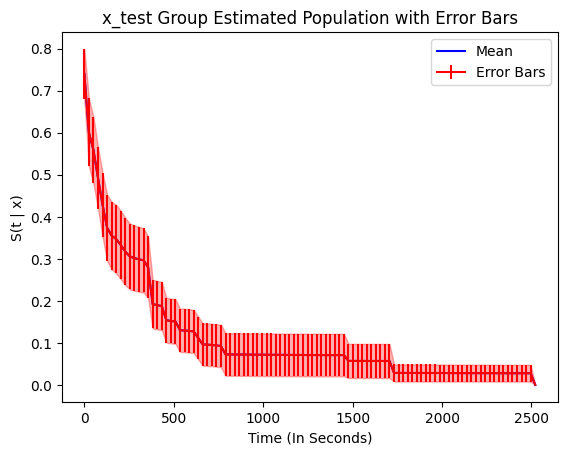

In [220]:
def graph_mean_and_sem(surv, group_name):
  surv['mean'] = surv.mean(axis=1)
  surv['sem'] = surv.sem(axis='columns')
  
  # Calculate the upper and lower error bounds
  surv['upper_bound'] = surv['mean'] + surv['sem']
  surv['lower_bound'] = surv['mean'] - surv['sem']

  # Create the figure and axis objects
  fig, ax = plt.subplots()

  # Plot the mean line
  ax.plot(surv.index, surv['mean'], color='blue', label='Mean')

  # Plot the error bars
  ax.errorbar(surv.index, surv['mean'], yerr=surv['sem'], color='red', label='Error Bars')

  # Fill between the upper and lower error bounds
  ax.fill_between(surv.index, surv['lower_bound'], surv['upper_bound'], color='red', alpha=0.3)

  # Set the axis labels and title
  ax.set_xlabel('Time (In Seconds)')
  ax.set_ylabel('S(t | x)')
  ax.set_title(f'{group_name} Group Estimated Population with Error Bars')

  # Add a legend
  ax.legend()

  # Show the plot
  plt.show()

graph_mean_and_sem(surv, 'x_test')

Low
0:	[0s / 0s],		train_loss: 13.0631,	val_loss: 10.3057
1:	[0s / 0s],		train_loss: 11.1760,	val_loss: 7.7722
2:	[0s / 0s],		train_loss: 9.8108,	val_loss: 6.8649
3:	[0s / 0s],		train_loss: 8.4780,	val_loss: 6.3005
4:	[0s / 0s],		train_loss: 7.3306,	val_loss: 5.8875
5:	[0s / 0s],		train_loss: 6.2334,	val_loss: 5.4891
6:	[0s / 0s],		train_loss: 5.4226,	val_loss: 5.0699
7:	[0s / 0s],		train_loss: 4.6302,	val_loss: 4.6890
8:	[0s / 0s],		train_loss: 4.1849,	val_loss: 4.3464
9:	[0s / 0s],		train_loss: 3.6344,	val_loss: 4.0344
10:	[0s / 0s],		train_loss: 3.1914,	val_loss: 3.8148
11:	[0s / 0s],		train_loss: 3.0055,	val_loss: 3.6416
12:	[0s / 0s],		train_loss: 2.9427,	val_loss: 3.5049
13:	[0s / 0s],		train_loss: 2.7599,	val_loss: 3.3847
14:	[0s / 0s],		train_loss: 2.6535,	val_loss: 3.2890
15:	[0s / 0s],		train_loss: 2.5511,	val_loss: 3.2041
16:	[0s / 0s],		train_loss: 2.4552,	val_loss: 3.1290
17:	[0s / 0s],		train_loss: 2.3995,	val_loss: 3.0525
18:	[0s / 0s],		train_loss: 2.3199,	val_loss: 2.9

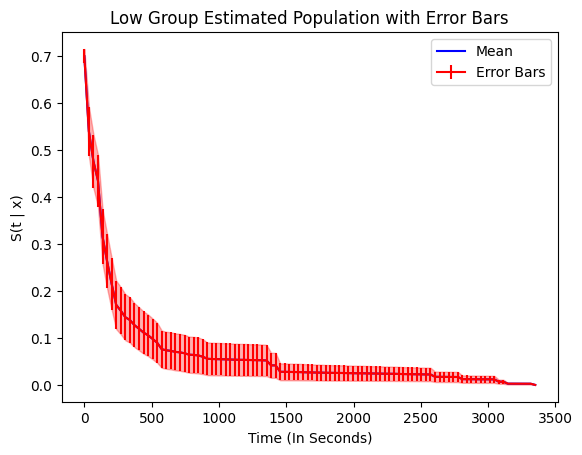

Medium
0:	[0s / 0s],		train_loss: 14.0214,	val_loss: 21.4689
1:	[0s / 0s],		train_loss: 12.0230,	val_loss: 14.1033
2:	[0s / 0s],		train_loss: 10.6451,	val_loss: 10.8795
3:	[0s / 0s],		train_loss: 9.2765,	val_loss: 8.8958
4:	[0s / 0s],		train_loss: 8.1052,	val_loss: 7.4687
5:	[0s / 0s],		train_loss: 6.9997,	val_loss: 6.4568
6:	[0s / 0s],		train_loss: 6.1593,	val_loss: 5.7416
7:	[0s / 0s],		train_loss: 5.4225,	val_loss: 5.2296
8:	[0s / 0s],		train_loss: 4.9306,	val_loss: 4.8763
9:	[0s / 0s],		train_loss: 4.4167,	val_loss: 4.6083
10:	[0s / 0s],		train_loss: 4.0628,	val_loss: 4.4334
11:	[0s / 0s],		train_loss: 3.9146,	val_loss: 4.2982
12:	[0s / 0s],		train_loss: 3.6843,	val_loss: 4.1972
13:	[0s / 0s],		train_loss: 3.5327,	val_loss: 4.1112
14:	[0s / 0s],		train_loss: 3.2812,	val_loss: 4.0274
15:	[0s / 0s],		train_loss: 3.1738,	val_loss: 3.9543
16:	[0s / 0s],		train_loss: 3.0159,	val_loss: 3.8992
17:	[0s / 0s],		train_loss: 2.9208,	val_loss: 3.8341
18:	[0s / 0s],		train_loss: 2.8286,	val_los

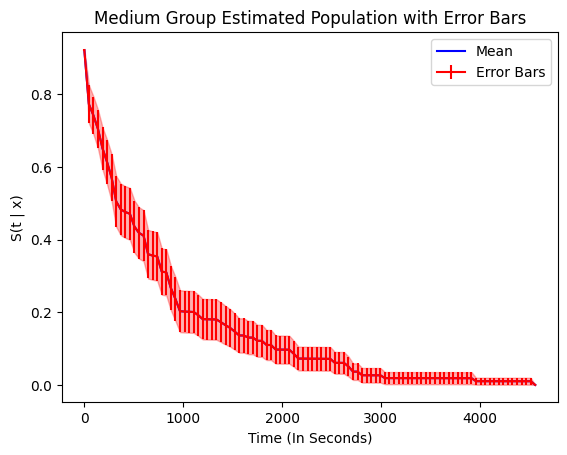

High
0:	[0s / 0s],		train_loss: 13.8646,	val_loss: 19.1890
1:	[0s / 0s],		train_loss: 11.1338,	val_loss: 13.2082
2:	[0s / 0s],		train_loss: 9.9742,	val_loss: 10.8842
3:	[0s / 0s],		train_loss: 8.7952,	val_loss: 9.3886
4:	[0s / 0s],		train_loss: 7.5432,	val_loss: 8.4134
5:	[0s / 0s],		train_loss: 6.1596,	val_loss: 7.6055
6:	[0s / 0s],		train_loss: 5.5948,	val_loss: 6.8848
7:	[0s / 0s],		train_loss: 5.0016,	val_loss: 6.2571
8:	[0s / 0s],		train_loss: 4.5466,	val_loss: 5.7852
9:	[0s / 0s],		train_loss: 4.0337,	val_loss: 5.4261
10:	[0s / 0s],		train_loss: 3.6982,	val_loss: 5.1342
11:	[0s / 0s],		train_loss: 3.4390,	val_loss: 4.9390
12:	[0s / 0s],		train_loss: 3.2264,	val_loss: 4.8011
13:	[0s / 0s],		train_loss: 3.0823,	val_loss: 4.7116
14:	[0s / 0s],		train_loss: 2.9202,	val_loss: 4.6479
15:	[0s / 0s],		train_loss: 2.9302,	val_loss: 4.6055
16:	[0s / 0s],		train_loss: 2.7269,	val_loss: 4.6136
17:	[0s / 0s],		train_loss: 2.5898,	val_loss: 4.6525
18:	[0s / 0s],		train_loss: 2.4175,	val_loss: 

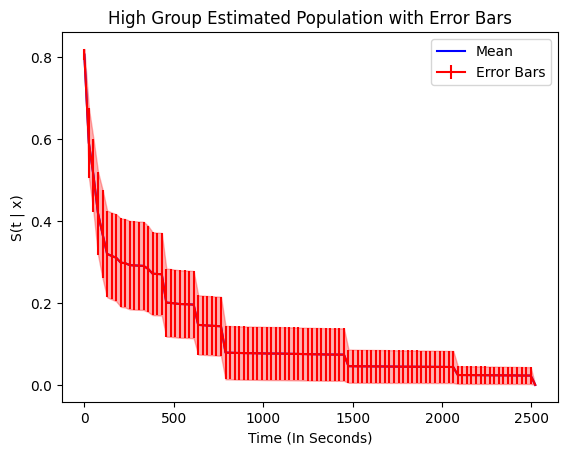

In [221]:
for group in temp_groups:
  print(group)
  df = temp_groups[group]
  cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']
  df_train = df[cols_input]
  fit_model, base_model, x_test = run_pycox_on_group(df_train)
  surv = base_model.predict_surv_df(x_test)
  graph_mean_and_sem(surv, group)
  # plot_training_val_loss(fit_model, base_model, x_test)
  
  

### Evaluation of trained model

Notes:
- From our graphed 5 rows from the `x_train` dataset we can see that the survival curves all have a sharp decrease after the first few seconds. 

TODO:
- Need to figure out why the discretization grid values are so strange
- 
~~- See if you can run the EvalSurv functions in google colab on the bee data~~

<Axes: >

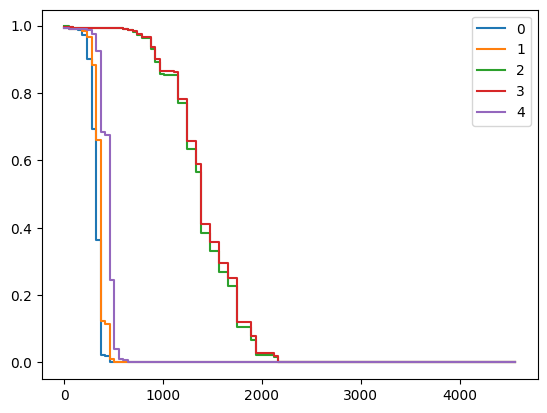

In [205]:
surv = model.predict_surv_df(x_test)

surv.iloc[:, :5].plot(drawstyle='steps-post')

In [206]:
surv

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0.000000,0.993094,9.923996e-01,9.975296e-01,9.974307e-01,9.919011e-01,0.992313,9.981144e-01,9.895545e-01,9.982418e-01,9.978545e-01,...,9.971469e-01,0.993544,9.982437e-01,9.978076e-01,0.993645,9.977598e-01,0.993256,0.993694,9.976665e-01,0.993093
46.070707,0.991448,9.911805e-01,9.958280e-01,9.956934e-01,9.909582e-01,0.786204,8.886230e-05,6.590930e-03,9.955771e-01,4.144204e-06,...,1.947538e-05,0.989394,9.974493e-01,9.958071e-01,0.988838,9.957992e-01,0.989869,0.982954,5.927388e-06,0.988604
92.141414,0.990951,9.908755e-01,9.941998e-01,9.940559e-01,9.907705e-01,0.257748,1.807560e-08,8.744721e-06,9.939058e-01,2.098821e-10,...,1.784974e-09,0.986590,9.966598e-01,9.941767e-01,0.985070,9.941694e-01,0.987871,0.965293,3.687313e-10,0.984944
138.212121,0.988005,9.898024e-01,9.941623e-01,9.940193e-01,9.905523e-01,0.004999,2.562216e-11,2.351337e-08,9.938884e-01,9.749839e-14,...,1.282742e-12,0.916988,9.966210e-01,9.941484e-01,0.877710,9.941400e-01,0.950814,0.376408,1.940815e-13,0.900036
184.282828,0.972379,9.850470e-01,9.941435e-01,9.940007e-01,9.899006e-01,0.000177,2.367107e-13,1.668953e-10,9.938697e-01,1.674998e-15,...,3.445847e-14,0.550006,9.966012e-01,9.941300e-01,0.407895,9.941216e-01,0.724839,0.017433,3.687718e-15,0.484131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4376.717172,0.000000,5.584202e-40,2.273056e-11,3.905966e-11,4.009626e-31,0.000000,0.000000e+00,0.000000e+00,8.058381e-04,0.000000e+00,...,0.000000e+00,0.000000,4.943412e-17,1.057795e-07,0.000000,3.945838e-08,0.000000,0.000000,0.000000e+00,0.000000
4422.787879,0.000000,4.197660e-40,2.260733e-11,3.885636e-11,3.561396e-31,0.000000,0.000000e+00,0.000000e+00,8.052393e-04,0.000000e+00,...,0.000000e+00,0.000000,4.873199e-17,1.054973e-07,0.000000,3.934227e-08,0.000000,0.000000,0.000000e+00,0.000000
4468.858586,0.000000,2.553250e-40,2.223473e-11,3.824935e-11,2.788960e-31,0.000000,0.000000e+00,0.000000e+00,8.041500e-04,0.000000e+00,...,0.000000e+00,0.000000,4.657033e-17,1.047825e-07,0.000000,3.904080e-08,0.000000,0.000000,0.000000e+00,0.000000
4514.929293,0.000000,1.879716e-40,2.212837e-11,3.807241e-11,2.415043e-31,0.000000,0.000000e+00,0.000000e+00,8.035435e-04,0.000000e+00,...,0.000000e+00,0.000000,4.596671e-17,1.045216e-07,0.000000,3.893431e-08,0.000000,0.000000,0.000000e+00,0.000000


0.000000       1.657799e-02
46.070707      5.616237e-02
92.141414      5.874873e-02
138.212121     6.054091e-02
184.282828     6.063597e-02
                   ...     
4376.717172    1.428921e-04
4422.787879    1.428332e-04
4468.858586    1.427417e-04
4514.929293    1.426796e-04
4561.000000    8.449807e-08
Name: sem, Length: 100, dtype: float32

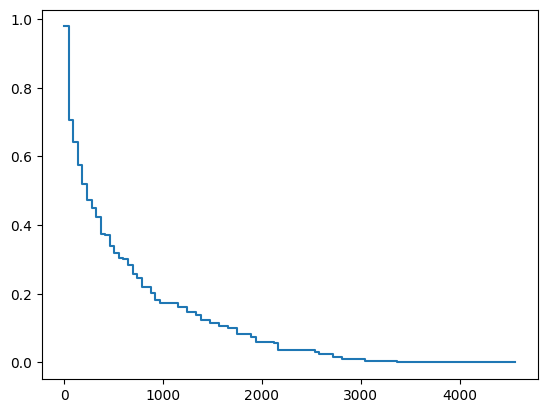

In [209]:
# calculate the mean and standard error mean
surv['mean'] = surv.mean(axis=1)
surv['sem'] = surv.sem(axis='columns')

surv['mean'].plot(drawstyle='steps-post')

surv['sem']

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,mean,sem
0.0,0.993094,0.9924,0.99753,0.997431,0.991901,0.992313,0.998114,0.989555,0.998242,0.997854,...,0.998244,0.997808,0.993645,0.99776,0.993256,0.993694,0.997667,0.993093,0.99491,0.000464


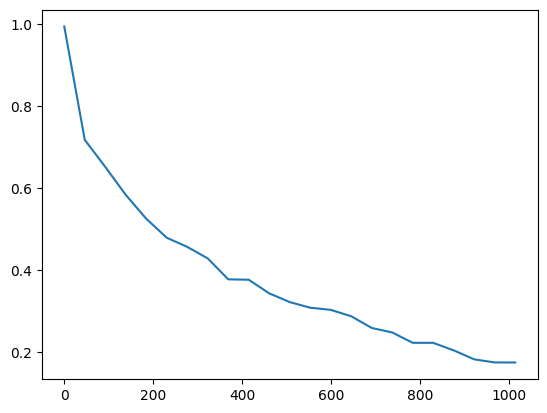

In [208]:
# Plotting the population survival curve for the time slice 0-1000 
surv['mean'].iloc[:23].plot()



# print(surv.iloc[:1].sem(axis='columns'))
surv.iloc[:1]

#### Tom's notes
- plot a few of the cross-sections with variance from the mean
- Get an error estimate from this graph
- Think about this as a box and whiskers
- Might find more opportunities for data-cleaning
- What do our different "treatment-groups" have in terms of error for this mean.
- Hypothesis testing: checking to see if there is clearly two different distributions rather than the same distribution with different params


TODO:
- Add Error bars to this graph
- On "treatment groups" run the whole pycox function and estimate population curves for the treatment groups. Then, compare not just the means but also standard errors
- We could run a hypothesis test on this output of the estimated population survival curves

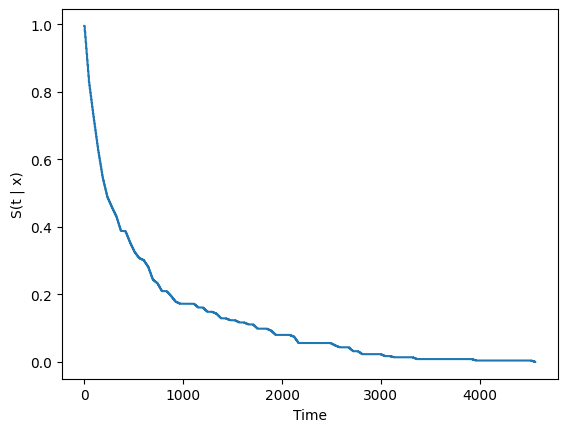

In [165]:

# start by interpolating
surv = model.interpolate(10).predict_surv_df(x_train)

# calculate the mean
surv['mean'] = surv.mean(axis=1)

surv['mean'].plot(drawstyle='steps-post')

plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

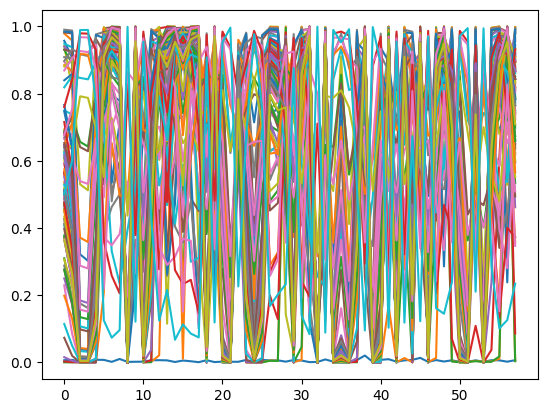

In [169]:
# _ = log.plot()
# log.to_pandas().val_loss.min()
# model.score_in_batches(val)
surv = model.predict_hazard(x_test)
# surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.plot(surv)
plt.show()
surv

model.save_model_weights('./model_weights.txt')

,0
0.000000,0.991516
45.161616,0.929533
90.323232,0.065003
135.484848,0.001136
180.646465,0.000010
...,...
4290.353535,0.000000
4335.515152,0.000000
4380.676768,0.000000
4425.838384,0.000000


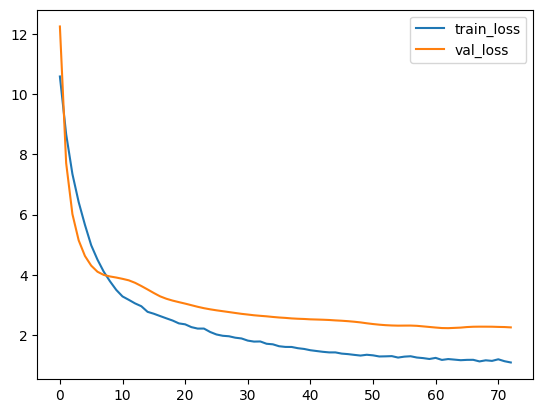

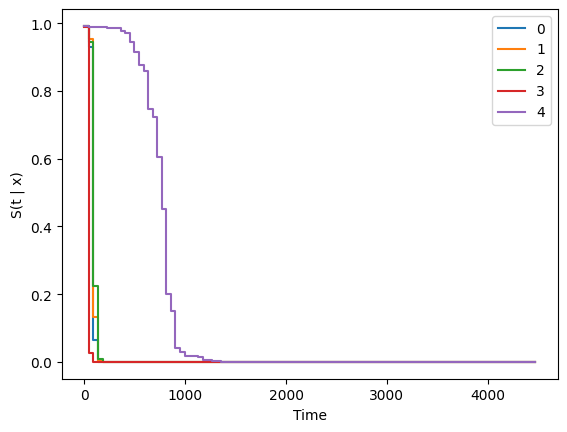

In [152]:
_ = log.plot()
log.to_pandas().val_loss.min()
model.score_in_batches(val)
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
# S(t | x) is the survival curve
# Assumption is this is the discrete data. The events they are fitting on is coming in discrete windows
# Our photo data has a consistent discretization grid in that we are checking in on the process every 30 seconds
# 
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
surv.iloc[:, :1]

- The plot below is the predicted survaval estimates of the first 5 individuals in the `x_test` dataset

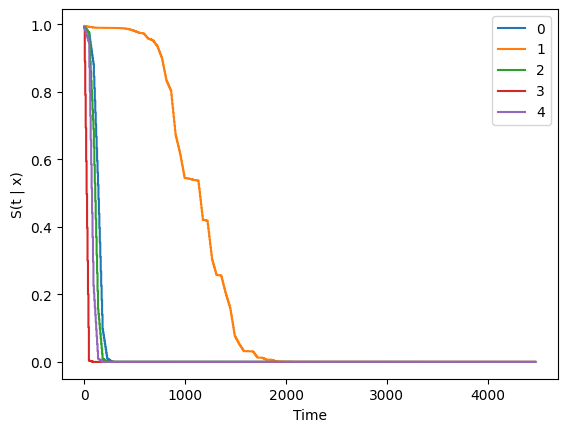

In [153]:
# TODO: Get some text output from this 
surv = model.interpolate(10).predict_surv_df(x_train)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [154]:
# surv_cdi = model.interpolate(100).predict_surv_df(x_test)
# ev_cdi = EvalSurv(surv_cdi, durations_test, events_test, censor_surv='km')
# ev_cdi.concordance_td()

### Getting information about model outcome


### Old Attempt for training

In [155]:
# Extract input features and output label
x = interval_and_weather_merged[['temp', 'dwpt', 'wspd', 'coco', 'same_insect']]
y = interval_and_weather_merged[['interval', 'status']]

x = x.astype({'same_insect': 'float64'})
y = y.astype({'interval': 'float64', 'status': 'float64'})

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(y_train.head())

# TODO: Skipping the step with the DataFrameMapper function



# Transform output label
get_target = lambda df: (df['interval'].values, df['status'].values)
labtrans = LogisticHazard.label_transform(cuts=100)
y_train_trans = labtrans.fit_transform(*get_target(y_train))

y_train_trans = (np.array(y_train_trans[0], dtype='float64'), np.array(y_train_trans[1], dtype='float64'))



# labtrans.cuts
print(type(labtrans.transform(*get_target(y_val))))
print(y_train_trans[1].dtype)
# print(x_train.values.dtype)

     interval  status
262    2062.0     1.0
271     314.0     1.0
268      67.0     1.0
73       76.0     1.0
25       14.0     1.0
<class 'tuple'>
float64


In [156]:

# Define model architecture
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

# Transform output label to `float64` for validation set
y_val_trans = labtrans.transform(*get_target(y_val))
y_val_trans = tuple(np.array(x, dtype='float64') for x in y_val_trans)
print(y_val_trans[0].dtype)
print(y_val_trans[1].dtype)
print(y_train_trans[0].dtype)
print(y_train_trans[1].dtype)
print(x_train.values.dtype)
print(x_val.values.dtype)
print(x_train.isna().sum())
print(y_train_trans.isna().sum())


# Train model
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
# Checking types 
log = model.fit(x_train.values, y_train_trans, batch_size, epochs, callbacks, val_data=(x_val.values, y_val_trans))


float64
float64
float64
float64
float64
float64
temp           0
dwpt           0
wspd           0
coco           0
same_insect    0
dtype: int64


AttributeError: 'tuple' object has no attribute 'isna'

In [ ]:
print("x_train shape:", x_train.values.shape)
print("y_train_trans[0] shape:", y_train_trans[0].shape)
print("y_train_trans[1] shape:", y_train_trans[1].shape)
print("x_val shape:", x_val.values.shape)
print("y_val_trans[0] shape:", y_val_trans[0].shape)
print("y_val_trans[1] shape:", y_val_trans[1].shape)

x_train shape: (233, 5)
y_train_trans[0] shape: (233,)
y_train_trans[1] shape: (233,)
x_val shape: (59, 5)
y_val_trans[0] shape: (59,)
y_val_trans[1] shape: (59,)


,0
0.000000,9.969695e-01
46.070707,9.942567e-01
92.141414,9.938170e-01
138.212121,9.938079e-01
184.282828,9.937838e-01
...,...
4376.717172,1.216293e-06
4422.787879,1.212397e-06
4468.858586,1.201899e-06
4514.929293,1.198898e-06


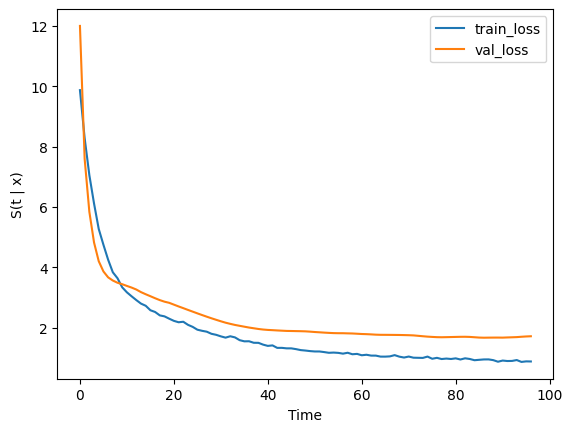

## Stacking Implimentation 
Pseudo Code
Create the predictor matrix and binary response vector for one observation/row
Okay so from the example in the Tibshirani paper what we will do for a given row of our data frame is take the `interval` value and check to see all of the other rows which interval values >= that ‘interval length
Then, we will make  a risk set with the index of our given row and all the rows that met the criteria above. 

Then, we will make our predictor matrix X(R(i)) with the covariants (temp, wspd, etc) for each row that met that hasn’t terminated yet as a row in the predictor matrix
 We then create a binary response vector \hat{y}(R(i)) 
Stack the binary response vectors
Stack the predictor matrix and add i columns for each observation in the risk set. And these column become indicator variables (1 or 0) for weather the observation corresponds to that ith member of the risk set. 
We know apply a binary classifier in order to predict the binary response vector using the predictor matrix. 
This is modeling the conditional proba of having an event at each failure time, having survived the past and previous failure times. 
TODO: Find a binary classification function and feed in our stacked predictor matrix and binary response vector. 
Statsmodels will have one. 


In [ ]:
def stack_dataframe(df):
  predictor_matrix_dfs = []
  binary_response_vector_df = []

  # iterate through each row in the dataframe
  for i, row in df.iterrows():
    # extract the 'interval' value of the current row
    current_interval = row['interval']
    print('current_interval', current_interval)
    print('index', i)
    # use boolean indexing to filter the rows where 'interval' value is greater than the current interval
    risk_set_df = df[df['interval'] >= current_interval]

    column_name = f"risk set {i}"  # set the column name variable
    predictor_df = risk_set_df.assign(**{column_name: 1}) 
    
    print('predictor_df', predictor_df)

    # add the risk_set_df dataframe to the list
    predictor_matrix_dfs.append(predictor_df)

    # create binary response vector
    current_row_predictor_matrix_index = predictor_df.index.get_loc(i)
    indicator_series = pd.Series([0] * len(risk_set_df))
    indicator_series[current_row_predictor_matrix_index] = 1

    print('indicator_series', indicator_series)
    # print('current_row', predictor_df.iloc[i])

    # add the binary response vector to the vector list 
    binary_response_vector_df.append(indicator_series)
  
  # combine predictor matrix dataframes horizontally
  stacked_predictor_df = pd.concat(predictor_matrix_dfs, axis=0)

  # combine binary response vector dataframes horizontally
  stacked_binary_response_df = pd.concat(binary_response_vector_df, axis=0)

  return stacked_predictor_df, stacked_binary_response_df
    

cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']
df_input = interval_and_weather_merged[cols_input]


stacked_predictor_df, stacked_binary_response_df = stack_dataframe(df_input)
stacked_predictor_df

# Replace NaN values with zeros for indicator columns `risk set 1`
stacked_predictor_df.fillna(0, inplace=True)

In [ ]:
stacked_binary_response_df
print(stacked_predictor_df.shape)
print(stacked_binary_response_df.shape)
print(stacked_binary_response_df.head())
stacked_predictor_df.head()


(42912, 253)
(42912,)
0    1
1    0
2    0
3    0
4    0
dtype: int64


,interval,status,temp,dwpt,wspd,coco,same_insect,risk set 0,risk set 1,risk set 2,...,risk set 288,risk set 289,risk set 290,risk set 291,risk set 292,risk set 293,risk set 294,risk set 295,risk set 296,risk set 297
0,150000000000,1,23.0,23.0,7.2,3.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1170000000000,1,23.0,23.0,7.2,3.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,660000000000,1,29.0,25.0,8.3,3.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2100000000000,1,21.0,18.9,6.0,3.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1620000000000,1,21.0,18.9,6.0,3.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Attempt at logistic regression
# TODO: normalize the variables and make sure they are all the same type like what you did for pyCox
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(stacked_predictor_df, stacked_binary_response_df)
LR.predict(stacked_predictor_df.iloc[:2,:])
LR.score(stacked_predictor_df, stacked_binary_response_df)

/Users/jonah/Personal/Native-Bee-Thesis/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9921234153616704